# K-Means Clustering

Your assignment is to use the TMDB 5000 dataset from Kaggle to try and cluster similar movies. 

It may be helpful to use PCA to reduce the dimensions of your data first - but then again maybe not. I dunno, you're the data scientist, you tell me. 🤪 

I'll let you download the dataset and get it into your notebook in the way that works best for you:

<https://www.kaggle.com/tmdb/tmdb-movie-metadata/version/2>

There are a few weird data cleaning steps that you'll need to do that I don't want you to get stuck on or spend a lot of time on so I'll try and help you out a little bit. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/tmdb_5000_movies.csv")
print(df.shape)
df.head()

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [24]:
# There's probably some pandas function that will do this but...
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in df.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = df.columns.difference(str_list)  

In [25]:
# Filter the dataframe by only the numeric columns
movies = df[num_list]
movies.head()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
0,237000000,19995,150.437577,2787965087,162.0,7.2,11800
1,300000000,285,139.082615,961000000,169.0,6.9,4500
2,245000000,206647,107.376788,880674609,148.0,6.3,4466
3,250000000,49026,112.312950,1084939099,165.0,7.6,9106
4,260000000,49529,43.926995,284139100,132.0,6.1,2124


In [26]:
# lazily fill NaNs with zeros
movies = movies.fillna(value=0, axis=1)

# You take it from here!

See what you can come up with. You have all the know-how! 

In [27]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

movies.head()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
0,237000000,19995,150.437577,2787965087,162.0,7.2,11800
1,300000000,285,139.082615,961000000,169.0,6.9,4500
2,245000000,206647,107.376788,880674609,148.0,6.3,4466
3,250000000,49026,112.312950,1084939099,165.0,7.6,9106
4,260000000,49529,43.926995,284139100,132.0,6.1,2124


In [28]:
print(movies.columns.values)


['budget' 'id' 'popularity' 'revenue' 'runtime' 'vote_average'
 'vote_count']


In [16]:
first_group = movies[['popularity', 'revenue']].groupby(['popularity'], as_index=False).mean().sort_values(by='revenue', ascending=False)
print(first_group)

      popularity     revenue
4783  150.437577  2787965087
4711  100.025899  1845034188
4779  144.448633  1519557910
4796  418.708552  1513528810
4721  102.322217  1506249360
4765  134.279229  1405403694
4785  165.125366  1274219009
4627   77.682080  1215439994
4801  875.581305  1156730962
4790  198.372395  1153304495
3609   28.529607  1123746996
4755  123.630332  1118888979
4693   93.004993  1108561013
4748  116.840296  1091405097
4739  112.312950  1084939099
4477   59.995418  1066969703
4781  145.847379  1065659812
4766  135.413856  1045713802
4633   78.530105  1025491110
4733  108.849621  1021103568
4788  187.322927  1004558444
4736  109.984351   976475550
4768  136.886704   970761885
4697   94.199316   966550600
4772  139.082615   961000000
4698   94.370564   958400000
4753  120.965743   956019788
4668   85.688789   940335536
4630   78.144395   938212738
4706   98.885637   933959197
...          ...         ...
1449    6.130231           0
1450    6.138213           0
1451    6.1388

In [17]:
second_group = movies[['popularity', 'vote_count']].groupby(['popularity'], as_index=False).mean().sort_values(by='vote_count', ascending=False)
print(second_group)

      popularity  vote_count
4786  167.583710     13752.0
4788  187.322927     12002.0
4783  150.437577     11800.0
4779  144.448633     11776.0
4799  514.569956     10995.0
4800  724.247784     10867.0
4653   82.121691     10099.0
4798  481.098624      9742.0
4571   68.550698      9455.0
4797  434.278564      9427.0
4782  146.757391      9413.0
4739  112.312950      9106.0
4725  104.309993      8907.0
4627   77.682080      8806.0
4752  120.725053      8776.0
4769  138.049577      8705.0
4796  418.708552      8662.0
4754  121.463076      8428.0
4733  108.849621      8297.0
4767  136.747729      8205.0
4755  123.630332      8064.0
4770  138.133331      7927.0
4693   93.004993      7604.0
4711  100.025899      7562.0
4729  106.914973      7487.0
4685   90.237920      7458.0
4743  115.040024      7359.0
4787  167.932870      7268.0
4790  198.372395      7241.0
4614   74.506246      7047.0
...          ...         ...
203     0.254659         0.0
207     0.278981         0.0
212     0.2839

In [37]:
movies_df = pd.DataFrame(movies, columns=['popularity','revenue','vote_count'])
print(movies_df)

      popularity     revenue  vote_count
0     150.437577  2787965087       11800
1     139.082615   961000000        4500
2     107.376788   880674609        4466
3     112.312950  1084939099        9106
4      43.926995   284139100        2124
5     115.699814   890871626        3576
6      48.681969   591794936        3330
7     134.279229  1405403694        6767
8      98.885637   933959197        5293
9     155.790452   873260194        7004
10     57.925623   391081192        1400
11    107.928811   586090727        2965
12    145.847379  1065659812        5246
13     49.046956    89289910        2311
14     99.398009   662845518        6359
15     53.978602   419651413        1630
16    144.448633  1519557910       11776
17    135.413856  1045713802        4948
18     52.035179   624026776        4160
19    120.965743   956019788        4760
20     89.866276   752215857        6586
21     37.668301   310669540        1398
22     94.370564   958400000        4524
23     42.990906

In [38]:
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
kmeans.fit(movies_df)
centroids = kmeans.cluster_centers_
print(centroids)

[[1.43099300e+01 2.71986250e+07 3.55231388e+02]
 [1.10125449e+02 8.05138728e+08 4.96328676e+03]
 [4.53750750e+01 2.56812225e+08 1.77671491e+03]]


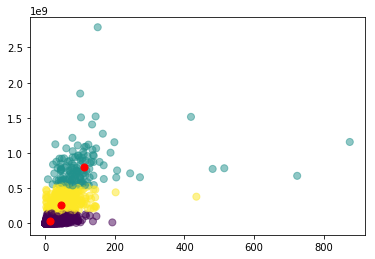

In [45]:
plt.scatter(movies_df['popularity'], movies_df['revenue'],  c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)

# Stretch Goal:

If you look at the original dataset you'll notice that I threw away some potentially useful columns. See if there are any that you could clean more effectively and turn into a numeric representation (probably some kind of one-hot-encoding of categorical variables) to assist your clustering. There's a lot more work here than the hours we have today however, so don't kill yourself trying to incorporate every single column from the original dataset, just take it one column at a time.

**Side Note** Data Science is never DONE. You just reach a point where the cost isn't worth the benefit anymore. There's always more moderate to small improvements that we could make. Don't be a perfectionist, be a pragmatist.